In [1]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import xgboost as xgb
import gc
import sys
import os
sys.path.append(os.path.abspath("../../.."))


from Preprocessing.preprocessing_pipeline_impute import preprocessing_pipeline
from Preprocessing.imputation import get_imputation_maps, apply_imputation,ContextImputer
from Preprocessing.preprocessing_pipeline_segment import preprocessing_pipeline_segment
from Preprocessing.split_new_drop_models import split_data
from utils.eval_call import evaluate_model
from utils.scatter_plot import scatter_prediction

Training XGBoost model...
XGBoost Performance Metrics:
MAE: 4026.71
MSE: 160367776.00
RMSE: 12663.64
R²: 0.87
------------------------------


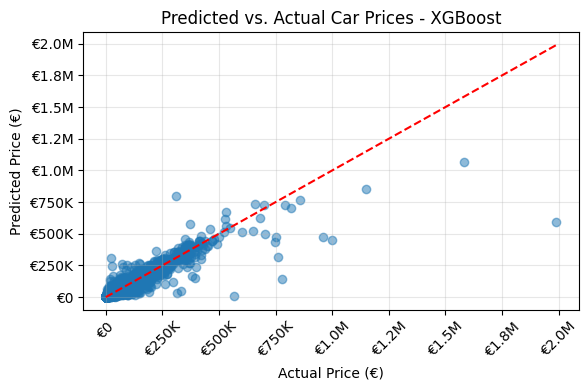

In [2]:
def main():
    # 1) Daten laden / splitten
    X_train, X_test, y_train, y_test, cat_feats, num_feats = split_data('../../../data.csv')
    
    # 2) Transformer
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, num_feats),
        ('cat', categorical_transformer, cat_feats)
    ])

    # 3) XGBoost-Pipeline
    xgb_pipeline = Pipeline([
        ('imp_fc', ContextImputer('fuel_consumption_l_100km')),
        ('imp_ps', ContextImputer('power_ps')),
        ('imp_er', ContextImputer('electric_range')),
        ('preprocessor', preprocessor),
        ('model', xgb.XGBRegressor(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=7,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        ))
    ])

    print("Training XGBoost model...")

    xgb_pipeline.fit(X_train, y_train)

    y_pred = xgb_pipeline.predict(X_test)
    evaluate_model(y_test, y_pred, "XGBoost")
    scatter_prediction(y_test, y_pred, "XGBoost")

if __name__ == "__main__":
    main()